In [61]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import time
import pdb

In [3]:
sys.path.append('..')

In [54]:
from utils import gen_covariance, gen_beta2, gen_data, get_cov_list

In [6]:
from sklearn.linear_model import LassoLars, lasso_path

In [ ]:
# From 'On the Degrees of Freedom' of the Lasso, it is suggested to use
# the optimal CP penalty to determine the optimal lambda penalty. In turn, we can use this to instead find the 
# degrees of freedom corresponding to the optimal lambda, and use this as an estimate of the sparsity

In [47]:
sigma = gen_covariance(100, 0, 100, 1, 0)
beta = gen_beta2(100, 100, 0.2)
X, X_test, y, y_test, ss = gen_data(300, 100, covariance = sigma, beta = beta)

In [48]:
alphas, coefs, _ = lasso_path(X, y)

In [49]:
np.count_nonzero(beta)

20

In [50]:
# For each set of coefficients along the regularization path, compute the CP score, then extract the degrees 
# of freedom associated with the best CP score:

cp_scores = np.zeros(len(alphas))
dfs = np.zeros(len(alphas))

for i, alpha in enumerate(alphas):
    
    y_pred = X_test @ coefs[0, :, i]
    df = np.count_nonzero(coefs[0, :, i])
    cp_scores[i] = CP(y_test, y_pred, df)
    dfs[i] = df

In [37]:
def CP(y_true, y_pred, df):
    n = y_true.size
    
    CP = 1/n * np.linalg.norm(y_true.ravel() - y_pred.ravel())**2 * (1 + np.log(n) * df/n)

    return CP
    

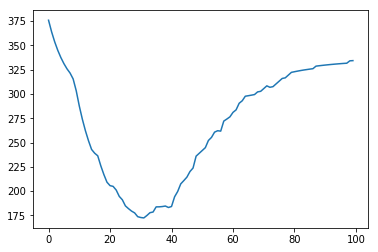

In [51]:
plt.plot(cp_scores)

In [52]:
np.argmin(cp_scores)

31

In [53]:
dfs[34]

22.0

In [ ]:
# Why can't we just use this model selection criteria for UoI itself?

# The rate of convergence for using separate test data seems to be much faster than for using the dataset itself 
# --> study scaling with respect to the number of samples

In [64]:
# How accurately does this approach recover the sparsity of the true model across the full range of sparsities and 
# correlation paramters?

# Generate the models
sparsity = np.linspace(0.05, 1, 20)

n_features = 100
n_samples = 300
block_sizes = [5, 10, 20]
correlation = [0, 0.0089137, 0.15811388, 0.28117066, 0.5]
L = [2, 5, 10, 20]

cov_params = [{'correlation': 0, 'block_size': 20, 'L': 1, 't': 0},
       {'correlation': 0.08891397, 'block_size': 20, 'L': 1, 't': 0},
       {'correlation': 0.28117066, 'block_size': 20, 'L': 1, 't': 0},
       {'correlation': 0.5, 'block_size': 20, 'L': 1, 't': 0},
       {'correlation': 1, 'block_size': 100, 'L': 2, 't': 1},
       {'correlation': 1, 'block_size': 100, 'L': 5, 't': 1},
       {'correlation': 1, 'block_size': 100, 'L': 10, 't': 1},
       {'correlation': 1, 'block_size': 100, 'L': 20, 't': 1},
       {'correlation': 0.5, 'block_size': 20, 'L': 20, 't': 0.9506632753385218}]


# Vary the betawidths as well
betawidth = [0, 0.5, np.inf, -10]

sparsity_error = np.zeros((len(sparsity), len(cov_params), len(betawidth)))
alt_sparsity_error = np.zeros((len(sparsity), len(cov_params), len(betawidth)))

for i, s in enumerate(sparsity):
    for j, cov_param in enumerate(cov_params):
        for k, bw in enumerate(betawidth):
            
            t0 = time.time()
            
            # Generate the data
            sigma = gen_covariance(n_features, **cov_param)
            beta = gen_beta2(n_features, cov_param['block_size'], s, bw)
            X, X_test, y, y_test, ss = gen_data(n_samples, n_features, 
                                                covariance = sigma, beta = beta)
            
            # Get the full coefficient path
            alphas, coefs, _ = lasso_path(X, y)
            
            cp_scores = np.zeros(len(alphas))
            dfs = np.zeros(len(alphas))

            alt_cp_scores = np.zeros(len(alphas))
            
            for ii, alpha in enumerate(alphas):

                y_pred = X_test @ coefs[0, :, ii]
                df = np.count_nonzero(coefs[0, :, ii])
                
                cp_scores[ii] = CP(y_test, y_pred, df)
                alt_cp_scores[ii] = CP(y, X @ coefs[0, :, ii], df)
                
                dfs[ii] = df
                
            # Select the degrees of freedom assocaited with the smallest score:
            sparsity_estimate = dfs[np.argmin(cp_scores)]
            alt_sparsity_estimate = dfs[np.argmin(alt_cp_scores)]
            
            se1 = np.linalg.norm(sparsity_estimate/n_features - s)
            se2 = np.linalg.norm(alt_sparsity_estimate/n_features - s)
            sparsity_error[i, j, k] = se1
            alt_sparsity_error[i, j, k] = se2
            
            print(time.time() - t0)

0.2713921070098877
0.13730120658874512
0.144730806350708
0.16742396354675293
0.17199206352233887
0.15486645698547363
0.1799933910369873
0.35179805755615234
0.2841958999633789
0.19451165199279785
0.3660573959350586
0.4000113010406494
0.5770139694213867
1.0267002582550049
0.5165762901306152
0.5014152526855469
0.25742101669311523
0.2624821662902832
0.4375011920928955
0.3366241455078125
0.4722416400909424
0.4646310806274414
0.5033187866210938
0.6389861106872559
0.8334352970123291
0.7817966938018799
0.6008241176605225
0.7610058784484863
1.3173890113830566
1.1383042335510254
1.1580023765563965
1.588587760925293
1.0204856395721436
0.9818668365478516
0.7887842655181885
2.070753574371338
0.15395402908325195
0.34124231338500977
0.1785900592803955
0.33010268211364746
0.2812032699584961
0.28345346450805664
0.17200803756713867
0.27355003356933594
0.2723402976989746
0.24751901626586914
0.24666953086853027
0.2889387607574463
0.613990306854248
1.2238132953643799
0.54630446434021
0.6716067790985107
0.4

1.1924107074737549
1.5233113765716553
0.22445082664489746
0.2550520896911621
0.3227837085723877
0.37473011016845703
0.2921013832092285
0.35802650451660156
0.2518758773803711
0.2906794548034668
0.4174838066101074
0.4059915542602539
0.3788564205169678
0.4802687168121338
0.7702798843383789
0.8454232215881348
0.964259147644043
1.189194679260254
0.41884565353393555
0.4730515480041504
0.4225733280181885
0.45421433448791504
0.7283873558044434
0.7708306312561035
0.8017063140869141
0.7758381366729736
1.042551040649414
1.0385453701019287
1.0827293395996094
1.3875157833099365
1.5943639278411865
2.239224672317505
1.8255062103271484
2.478106737136841
1.1166143417358398
1.188119888305664
1.0400581359863281
1.3467059135437012
0.22507476806640625
0.2194061279296875
0.20953845977783203
0.2990279197692871
0.22404217720031738
0.2543914318084717
0.39229369163513184
0.3159325122833252
0.7627606391906738
0.4960196018218994
0.5134692192077637
1.026618480682373
1.6745235919952393
2.563643217086792
1.288509130

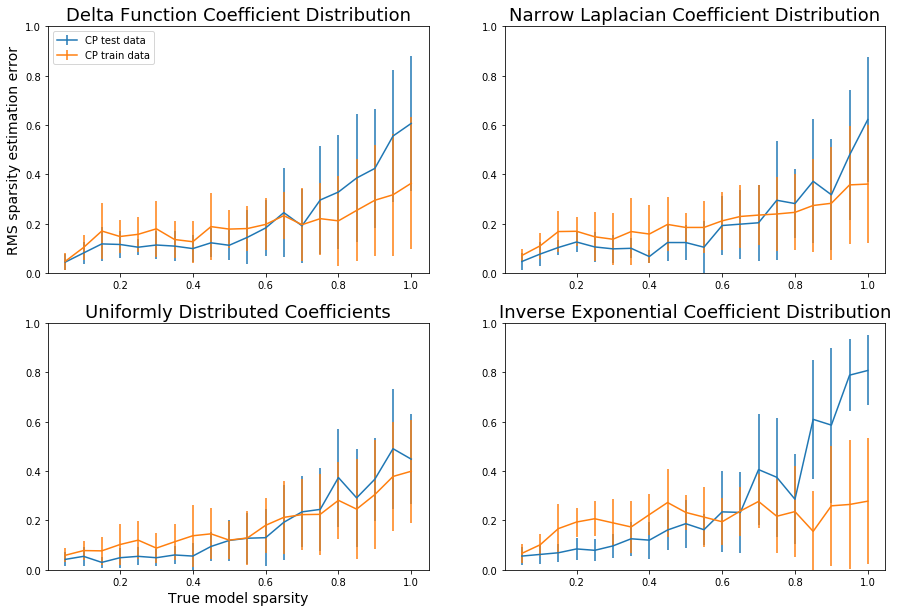

In [77]:
# Plot colormap of sparsity estimation error versus average correlation and sparsity

fig, ax = plt.subplots(2, 2, figsize = (15, 10))

for i, bw in enumerate(betawidth):
    a = ax[np.unravel_index(i, (2, 2))]
    
    # Calculate mean and average across correlation designs
    x1 = np.mean(sparsity_error[..., i], axis = 1)
    x1err = np.std(sparsity_error[..., i], axis = 1)
    
    x2 = np.mean(alt_sparsity_error[..., i], axis = 1)
    x2err = np.std(alt_sparsity_error[..., i], axis = 1)
    
    a.errorbar(sparsity, x1, x1err)
    a.errorbar(sparsity, x2, x2err)
 
    a.set_ylim([0, 1])

    
ax[0, 0].set_ylabel('RMS sparsity estimation error', fontsize = 14)
ax[1, 0].set_xlabel('True model sparsity', fontsize = 14)
    
ax[0, 0].legend(['CP test data', 'CP train data'], loc = 'upper left')
ax[0, 0].set_title('Delta Function Coefficient Distribution', fontsize = 18)
ax[0, 1].set_title('Narrow Laplacian Coefficient Distribution', fontsize = 18)
ax[1, 0].set_title('Uniformly Distributed Coefficients', fontsize = 18)
ax[1, 1].set_title('Inverse Exponential Coefficient Distribution', fontsize = 18)

plt.savefig('sparsity_estimation.pdf', bbox_inches = 'tight', pad_inches = 0)